Computer Vision

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import json
import random

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

if not os.path.exists('./data'):
    os.mkdir('./data')


FIND_PARAMS = False


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)

mean_ = dataset.data.mean(axis=(0, 1, 2)) / 255
std_ = dataset.data.std(axis=(0, 1, 2)) / 255
mean_, std_

100%|██████████| 170498071/170498071 [00:05<00:00, 30553973.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean_, std_)])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

classes = train_dataset.classes

if os.sys.platform.startswith('darwin') and torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"We're going to train models on {device}.")

Files already downloaded and verified
Files already downloaded and verified
We're going to train models on cuda.


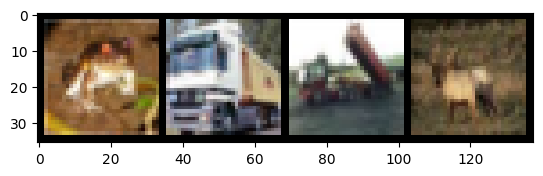

frog  truck truck deer 


In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    # npimg = npimg * std_.reshape(-1, 1, 1) + mean_.reshape(-1, 1, 1)  # unnormalize
    # npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[label]:5s}' for label in labels))

In [ ]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(SoftmaxRegression, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
        self.softmax = torch.nn.Softmax(1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        y = self.softmax(x)
        return y


In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def train_test(model, device, criterion, optimizer, train_loader, test_loader):
    EPOCHS = 20
    y_true, y_pred = [], []

    for epoch in range(EPOCHS):
        last_epoch = epoch == EPOCHS - 1
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                predictions = model(inputs)

                _, predicted = torch.max(predictions, 1)
                if last_epoch:
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

    score = f1_score(y_true, y_pred, average='macro')
    # print(y_true, y_pred)

    return score

criterion = nn.CrossEntropyLoss()


In [ ]:
if FIND_PARAMS:
    trainset_size = len(train_dataset)
    train_indices = list(range(trainset_size))
    train_split = int(np.floor(0.2 * trainset_size))

    np.random.seed(42)
    np.random.shuffle(train_indices)

    train_indices = train_indices[: train_split]
    train_sampler = SubsetRandomSampler(train_indices)

    set_seed(42)
    param_grid = {
        'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10)),
        'batch_size': [1, 128, 256, 512],
        'optimizer': [optim.SGD, optim.Adagrad, optim.Adam, optim.Adadelta]
    }

    MAX_EVALS = 100

    best_score = 0
    best_hyperparams = {}
    for i in tqdm(range(MAX_EVALS), ascii="123456789$", desc="Searching Hyperparams"):
        random.seed(i)
        model = SoftmaxRegression(3 * 32 * 32, 10).to(device)

        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        learning_rate = hyperparameters['learning_rate']
        batch_size = hyperparameters['batch_size']
        optimizer = hyperparameters['optimizer'](model.parameters(), lr=learning_rate)

        train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=2, sampler=train_sampler)
        test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

        score = train_test(
                    model, device, criterion, optimizer, train_loader, test_loader)

        if score > best_score:
            best_hyperparams = hyperparameters
            best_score = score
            print(f'New best score: {best_score}\nparams: {hyperparameters}')
        # break
else:
        best_hyperparams = {
            "learning_rate": 0.007999293598030286,
            "batch_size": 128,
            "optimizer": optim.Adagrad}

In [ ]:
print(best_hyperparams)

model = SoftmaxRegression(3 * 32 * 32, 10).to(device)

learning_rate = best_hyperparams['learning_rate']
batch_size = best_hyperparams['batch_size']
optimizer = best_hyperparams['optimizer'](model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


train_loss, test_loss = [], []
train_acc, test_acc = [], []

EPOCHS = 20
for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        optimizer.zero_grad()

        loss = criterion(predictions, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    running_loss = 0.
    correct, total = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)

            running_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss.append(running_loss / len(test_loader))
    test_acc.append(correct / total)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Test Loss:", round(test_loss[epoch], 3))

        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Test Accuracy:", round(test_acc[epoch], 3))

        print("------------------------------")

{'learning_rate': 0.007999293598030286, 'batch_size': 128, 'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
Epoch 5:
Training Loss: 2.03
Test Loss: 2.053
Training Accuracy: 0.431
Test Accuracy: 0.41
------------------------------
Epoch 10:
Training Loss: 2.017
Test Loss: 2.049
Training Accuracy: 0.449
Test Accuracy: 0.414
------------------------------
Epoch 15:
Training Loss: 2.01
Test Loss: 2.05
Training Accuracy: 0.458
Test Accuracy: 0.409
------------------------------
Epoch 20:
Training Loss: 2.006
Test Loss: 2.048
Training Accuracy: 0.463
Test Accuracy: 0.415
------------------------------


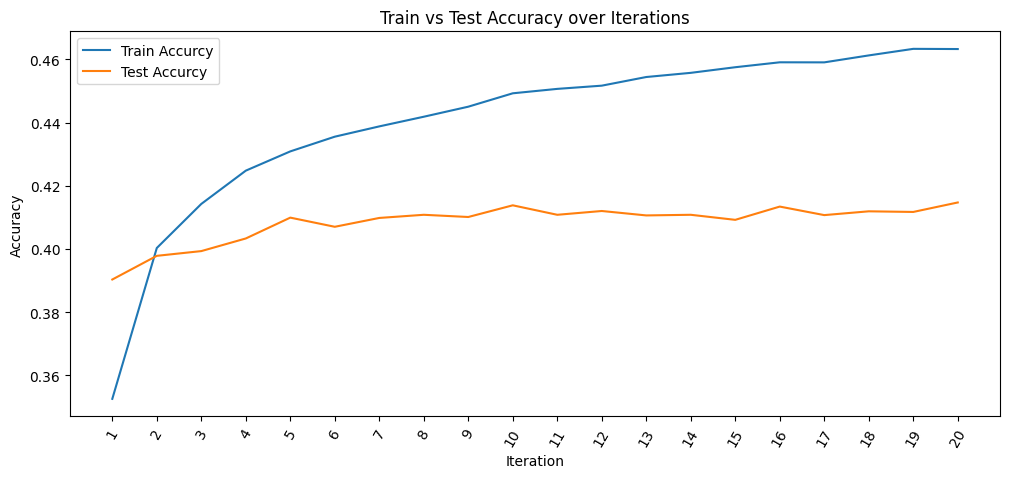

In [ ]:
x = np.arange(1, EPOCHS + 1)

plt.figure(1, (12, 5))

plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.xticks(x, rotation=60)

plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.legend(['Train Accurcy', 'Test Accurcy'])

plt.title('Train vs Test Accuracy over Iterations')
plt.show();

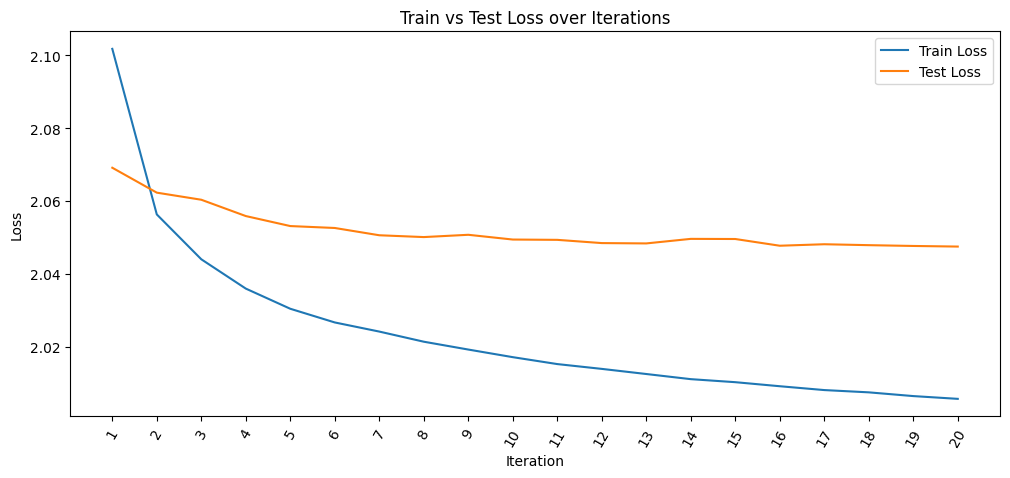

In [ ]:
plt.figure(1, (12, 5))

plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.xticks(x, rotation=60)

plt.xlabel('Iteration')
plt.ylabel('Loss')


plt.legend(['Train Loss', 'Test Loss'])

plt.title('Train vs Test Loss over Iterations')
plt.show();